## Predicting Survivors on Kaggle Competition on Titanic
### https://www.kaggle.com/c/titanic/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

%matplotlib inline

In [3]:
# Following data files were downloaded from respective Kaggle competition

train_data = pd.read_csv("train.csv")                           # 891 rows
test_data = pd.read_csv("test.csv")                             # 418 rows
gender_submission_data = pd.read_csv("gender_submission.csv")   # 418 rows

In [4]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
# Checks for correlations in training data
train_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [6]:
# Checks for missing data in train and test data
pd.DataFrame({"Train Data": train_data.isna().sum(), "Test Data": test_data.isna().sum()})

,Train Data,Test Data
Age,177,86.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,1.0
Name,0,0.0
Parch,0,0.0
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
SibSp,0,0.0


In [7]:
# To fill in missing ages in both train and test data, let's check for the average age group by Pclass and Sex

train_data.groupby(['Pclass', 'Sex']).mean()

PassengerId  Survived        Age     SibSp     Parch  \
Pclass Sex                                                            
1      female   469.212766  0.968085  34.611765  0.553191  0.457447   
       male     455.729508  0.368852  41.281386  0.311475  0.278689   
2      female   443.105263  0.921053  28.722973  0.486842  0.605263   
       male     447.962963  0.157407  30.740707  0.342593  0.222222   
3      female   399.729167  0.500000  21.750000  0.895833  0.798611   
       male     455.515850  0.135447  26.507589  0.498559  0.224784   

                     Fare  
Pclass Sex                 
1      female  106.125798  
       male     67.226127  
2      female   21.970121  
       male     19.741782  
3      female   16.118810  
       male     12.661633

In [8]:
# Now, fill in missing values for ages with average value of ages Pclass and Sex wise in both train and test data.

train_data.Age = train_data.Age.fillna(train_data.groupby(['Pclass', 'Sex']).Age.transform('mean'))
test_data.Age = test_data.Age.fillna(test_data.groupby(['Pclass', 'Sex']).Age.transform('mean'))

In [9]:
# There is a missing value for Fare in test data, not in train data. Let's check that out.

test_data.query("Fare == 'NaN'")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [10]:
# To fill in for this missing value, let's checks for average Fare group by Sex
test_data.query("Pclass == 3 & SibSp == 0 & Parch == 0 & Embarked == 'S'").groupby(["Sex"]).Fare.mean()

Sex
female    10.476306
male       9.096775
Name: Fare, dtype: float64

In [11]:
# Now, fill in the missing value with the average value
test_data.Fare = test_data.Fare.fillna(
    test_data.groupby(['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']).Fare.transform('mean'))

In [12]:
# Now, make sure there is no more missing value left in train and test data except column Cabin.
pd.DataFrame({"Train Data": train_data.isna().sum(), "Test Data": test_data.isna().sum()})

,Train Data,Test Data
Age,0,0.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,0.0
Name,0,0.0
Parch,0,0.0
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
SibSp,0,0.0


In [13]:
# Now, checks for correlations among features
train_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.039636,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.067485,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.407015,0.083081,0.018443,-0.549500
Age,0.039636,-0.067485,-0.407015,1.000000,-0.251313,-0.180705,0.118308
SibSp,-0.057527,-0.035322,0.083081,-0.251313,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.180705,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.118308,0.159651,0.216225,1.000000


In [14]:
# Let's check the importance of column Embarked to pasengers' survival.

train_data.groupby(["Embarked"]).mean()

# And, from the below observation, it is not clear whether Embarked should be considered a feature of not.
# So, let's build model without consider this as feature for now, and validate.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,445.357143,0.553571,1.886905,30.461519,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,25.690425,0.428571,0.168831,13.276030
S,449.527950,0.336957,2.350932,29.390082,0.571429,0.413043,27.079812


In [15]:
# Cabin collumn was revmoved because around 80% of data is missing from both test and training data.
# Columns PassengerId, Name, ticket, Age, SibSp, Parch, Cabin and Embarked were also removed 
# considering not relevant for prediction for now.
train_data.drop(["PassengerId", "Name", "Ticket", "Age", "SibSp", "Parch", "Cabin", "Embarked"], axis=1, inplace=True)
test_data.drop(["PassengerId", "Name", "Ticket", "Age", "SibSp", "Parch", "Cabin", "Embarked"], axis=1, inplace=True)

In [16]:
# From the below analysis, it shows that survivors were females in majority.

train_data.groupby(["Sex", "Pclass"]).mean()

Survived        Fare
Sex    Pclass                      
female 1       0.968085  106.125798
       2       0.921053   21.970121
       3       0.500000   16.118810
male   1       0.368852   67.226127
       2       0.157407   19.741782
       3       0.135447   12.661633

In [17]:
# Performs One-Hot-Encoding on 'Sex' and 'Pclass' column in both Train and Test data sets

train_data = train_data.join(pd.get_dummies(train_data.Pclass, prefix="Pclass")).drop(["Pclass"], axis=1)
test_data = test_data.join(pd.get_dummies(test_data.Pclass, prefix="Pclass")).drop(["Pclass"], axis=1)

train_data = train_data.join(pd.get_dummies(train_data.Sex, prefix="Sex")).drop(["Sex"], axis=1)
test_data = test_data.join(pd.get_dummies(test_data.Sex, prefix="Sex")).drop(["Sex"], axis=1)

### Decision Tree - Let's first get started with it

In [18]:
# Creates training label
y = train_data.Survived

# Creates a dataset with feates we are interested in
X = train_data.drop(["Survived"], axis=1)

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

#### Let's first get predictions on default Decision Tree model.

In [19]:
# Creates model without max. leaf nodes parameter
dt_model = DecisionTreeClassifier(random_state=1)

# Fits model
dt_model.fit(train_X, train_y)

# Performes predictions on validation data and calculates mean absolute error
dt_val_predictions = dt_model.predict(val_X)
dt_val_accuracy = accuracy_score(dt_val_predictions, val_y)
print("Validation accuracy when not specifying max_leaf_nodes:", dt_val_accuracy)

Validation accuracy when not specifying max_leaf_nodes: 0.8475336322869955


#### Now, create Decision Tree model by passing variying number of max. leaf nodes as parameter and observe prediction performance.

In [20]:
# Creates a list to store the accuracies against validation data
dt_val_accuracies = []

In [21]:
# Now, loops through max. leaf nodes count and store accuracy

for i in range(2, 500):
    dt_model = DecisionTreeClassifier(max_leaf_nodes=i, random_state=1)
    dt_model.fit(train_X, train_y)
    dt_val_predictions = dt_model.predict(val_X)
    dt_val_accuracy = accuracy_score(dt_val_predictions, val_y)
    print("Max. Leaf Nodes: ", i, "Validation Accuracy:", dt_val_accuracy)
    dt_val_accuracies.append(dt_val_accuracy)

Max. Leaf Nodes:  2 Validation Accuracy: 0.7847533632286996
Max. Leaf Nodes:  3 Validation Accuracy: 0.7533632286995515
Max. Leaf Nodes:  4 Validation Accuracy: 0.8026905829596412
Max. Leaf Nodes:  5 Validation Accuracy: 0.8026905829596412
Max. Leaf Nodes:  6 Validation Accuracy: 0.8071748878923767
Max. Leaf Nodes:  7 Validation Accuracy: 0.8071748878923767
Max. Leaf Nodes:  8 Validation Accuracy: 0.8071748878923767
Max. Leaf Nodes:  9 Validation Accuracy: 0.8071748878923767
Max. Leaf Nodes:  10 Validation Accuracy: 0.8071748878923767
Max. Leaf Nodes:  11 Validation Accuracy: 0.8071748878923767
Max. Leaf Nodes:  12 Validation Accuracy: 0.8071748878923767
Max. Leaf Nodes:  13 Validation Accuracy: 0.8116591928251121
Max. Leaf Nodes:  14 Validation Accuracy: 0.8116591928251121
Max. Leaf Nodes:  15 Validation Accuracy: 0.8295964125560538
Max. Leaf Nodes:  16 Validation Accuracy: 0.8295964125560538
Max. Leaf Nodes:  17 Validation Accuracy: 0.8116591928251121
Max. Leaf Nodes:  18 Validation 

Max. Leaf Nodes:  173 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  174 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  175 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  176 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  177 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  178 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  179 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  180 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  181 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  182 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  183 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  184 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  185 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  186 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  187 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  188 Validation Accuracy: 0.8475336322869955
Max. Lea

Max. Leaf Nodes:  340 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  341 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  342 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  343 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  344 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  345 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  346 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  347 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  348 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  349 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  350 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  351 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  352 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  353 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  354 Validation Accuracy: 0.8475336322869955
Max. Leaf Nodes:  355 Validation Accuracy: 0.8475336322869955
Max. Lea

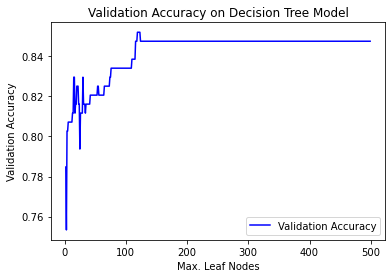

In [22]:
# Now, plots validation accuracies to visualize

plt.plot(range(2, 500), dt_val_accuracies[:], "b", label="Validation Accuracy")
plt.title("Validation Accuracy on Decision Tree Model")
plt.xlabel("Max. Leaf Nodes")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

In [23]:
# It seems from the above plot that validation accuracy is hightest at some point when value of max. leaf nodes is 
# somewhere between 50 and 100. Let's find that.

dt_val_accuracy_max = max(dt_val_accuracies)

print("So, the hightest validation accuracy for validation data ", dt_val_accuracy_max,
     "and the value for max. leaf nodes for which it is the highest is ", 
      dt_val_accuracies.index(dt_val_accuracy_max) + 2)

So, the hightest validation accuracy for validation data  0.852017937219731 and the value for max. leaf nodes for which it is the highest is  119


### Random Forest - Now, build model on it and compare its performance with that of Decision Tree

In [24]:
# Creates model without max. leaf nodes parameter
rf_model = RandomForestClassifier(random_state=1) #random_state=1

# Fits model
rf_model.fit(train_X, train_y)

# Performes predictions on validation data and calculates mean absolute error
rf_val_predictions = rf_model.predict(val_X)
rf_val_accuracy = accuracy_score(rf_val_predictions, val_y)
print("Validation accuracy when not specifying max_leaf_nodes:", rf_val_accuracy)

Validation accuracy when not specifying max_leaf_nodes: 0.8430493273542601


In [25]:
# Creates a list to store the accuracy against validation data
rf_val_accuracies = []

In [26]:
# Now, loops through max. leaf nodes count and store accuracy

for i in range(2, 200):
    rf_model = RandomForestClassifier(max_leaf_nodes=i, random_state=1)  
    rf_model.fit(train_X, train_y)
    rf_val_predictions = rf_model.predict(val_X)
    rf_val_accuracy = accuracy_score(rf_val_predictions, val_y)
    print("Max. Leaf Nodes: ", i, "Validation Accuracy:", rf_val_accuracy)
    rf_val_accuracies.append(rf_val_accuracy)

Max. Leaf Nodes:  2 Validation Accuracy: 0.7847533632286996
Max. Leaf Nodes:  3 Validation Accuracy: 0.7533632286995515
Max. Leaf Nodes:  4 Validation Accuracy: 0.7668161434977578
Max. Leaf Nodes:  5 Validation Accuracy: 0.8026905829596412
Max. Leaf Nodes:  6 Validation Accuracy: 0.8026905829596412
Max. Leaf Nodes:  7 Validation Accuracy: 0.8116591928251121
Max. Leaf Nodes:  8 Validation Accuracy: 0.8161434977578476
Max. Leaf Nodes:  9 Validation Accuracy: 0.8161434977578476
Max. Leaf Nodes:  10 Validation Accuracy: 0.820627802690583
Max. Leaf Nodes:  11 Validation Accuracy: 0.8161434977578476
Max. Leaf Nodes:  12 Validation Accuracy: 0.820627802690583
Max. Leaf Nodes:  13 Validation Accuracy: 0.820627802690583
Max. Leaf Nodes:  14 Validation Accuracy: 0.820627802690583
Max. Leaf Nodes:  15 Validation Accuracy: 0.820627802690583
Max. Leaf Nodes:  16 Validation Accuracy: 0.820627802690583
Max. Leaf Nodes:  17 Validation Accuracy: 0.820627802690583
Max. Leaf Nodes:  18 Validation Accurac

Max. Leaf Nodes:  138 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  139 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  140 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  141 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  142 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  143 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  144 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  145 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  146 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  147 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  148 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  149 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  150 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  151 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  152 Validation Accuracy: 0.8430493273542601
Max. Leaf Nodes:  153 Validation Accuracy: 0.8430493273542601
Max. Lea

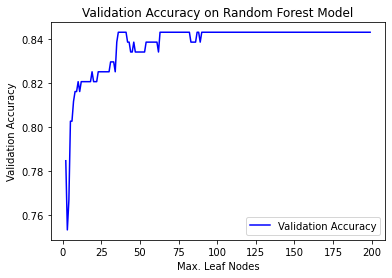

In [27]:
# Now, plots validation accuracies to visualize

plt.plot(range(2, 200), rf_val_accuracies[:], "b", label="Validation Accuracy")
plt.title("Validation Accuracy on Random Forest Model")
plt.xlabel("Max. Leaf Nodes")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

In [28]:
# It seems from the above plot that validation accuracy is getting highest when value of max. leaf nodes is 
# somewhere between 30 and 40.

rf_val_accuracy_max = max(rf_val_accuracies)

print("So, the highest accuracy for validation data is ", rf_val_accuracy_max,
     "and the value for max. leaf nodes for which it is highest is ", 
      rf_val_accuracies.index(rf_val_accuracy_max)+2)

So, the highest accuracy for validation data is  0.8430493273542601 and the value for max. leaf nodes for which it is highest is  36


In [29]:
# With validation error noted from the traning, let's combine validation back with training data and
# perform retraiing to final model.

train_X = pd.concat([train_X, val_X], axis=0)
train_y = pd.concat([train_y, val_y], axis=0)

In [30]:
print(train_X.shape, train_y.shape, test_data.shape)

(891, 6) (891,) (418, 6)


In [31]:
# Creates model without max. leaf nodes parameter
rf_model = RandomForestClassifier(max_leaf_nodes=36, random_state=1)

# Fits model
rf_model.fit(train_X, train_y)

# Performes predictions on validation data and calculates mean absolute error
rf_predictions = rf_model.predict(test_data)

In [32]:
rf_predictions.shape

(418,)

In [33]:
gender_submission_data.drop(["Survived"], axis=1, inplace=True)

In [34]:
gender_submission_data.shape

(418, 1)

In [35]:
gender_submission_data["Survived"] = pd.Series(rf_predictions, name="Survived")

In [36]:
gender_submission_data.to_csv("Predictions.csv", index=False)

In [37]:
# The above submission without Age, SibSp, Parch, Cabin and Embarked features scored ~0.76 in Kaggle submission.
# There seems to be defnite scope for improvement...

### Gradient Boost - Now, build model on it and compare its performance with that of Decision Tree and Random Forest

In [50]:
xgb_model = xgb.XGBClassifier(n_estimators=1000)

In [51]:
xgb_model.fit(train_X, train_y, eval_set=[(val_X, val_y)])

[0]	validation_0-error:0.183857
[1]	validation_0-error:0.183857
[2]	validation_0-error:0.197309
[3]	validation_0-error:0.183857
[4]	validation_0-error:0.197309
[5]	validation_0-error:0.197309
[6]	validation_0-error:0.197309
[7]	validation_0-error:0.197309
[8]	validation_0-error:0.197309
[9]	validation_0-error:0.197309
[10]	validation_0-error:0.197309
[11]	validation_0-error:0.197309
[12]	validation_0-error:0.197309
[13]	validation_0-error:0.197309
[14]	validation_0-error:0.197309
[15]	validation_0-error:0.197309
[16]	validation_0-error:0.197309
[17]	validation_0-error:0.197309
[18]	validation_0-error:0.197309
[19]	validation_0-error:0.197309
[20]	validation_0-error:0.197309
[21]	validation_0-error:0.197309
[22]	validation_0-error:0.197309
[23]	validation_0-error:0.197309
[24]	validation_0-error:0.197309
[25]	validation_0-error:0.179372
[26]	validation_0-error:0.179372
[27]	validation_0-error:0.174888
[28]	validation_0-error:0.174888
[29]	validation_0-error:0.174888
[30]	validation_0-er

[245]	validation_0-error:0.121076
[246]	validation_0-error:0.121076
[247]	validation_0-error:0.121076
[248]	validation_0-error:0.121076
[249]	validation_0-error:0.121076
[250]	validation_0-error:0.121076
[251]	validation_0-error:0.121076
[252]	validation_0-error:0.121076
[253]	validation_0-error:0.121076
[254]	validation_0-error:0.121076
[255]	validation_0-error:0.121076
[256]	validation_0-error:0.121076
[257]	validation_0-error:0.121076
[258]	validation_0-error:0.121076
[259]	validation_0-error:0.121076
[260]	validation_0-error:0.121076
[261]	validation_0-error:0.121076
[262]	validation_0-error:0.121076
[263]	validation_0-error:0.121076
[264]	validation_0-error:0.121076
[265]	validation_0-error:0.125561
[266]	validation_0-error:0.125561
[267]	validation_0-error:0.125561
[268]	validation_0-error:0.125561
[269]	validation_0-error:0.125561
[270]	validation_0-error:0.125561
[271]	validation_0-error:0.125561
[272]	validation_0-error:0.125561
[273]	validation_0-error:0.125561
[274]	validati

[486]	validation_0-error:0.107623
[487]	validation_0-error:0.107623
[488]	validation_0-error:0.107623
[489]	validation_0-error:0.107623
[490]	validation_0-error:0.107623
[491]	validation_0-error:0.107623
[492]	validation_0-error:0.107623
[493]	validation_0-error:0.107623
[494]	validation_0-error:0.107623
[495]	validation_0-error:0.107623
[496]	validation_0-error:0.107623
[497]	validation_0-error:0.107623
[498]	validation_0-error:0.107623
[499]	validation_0-error:0.107623
[500]	validation_0-error:0.107623
[501]	validation_0-error:0.107623
[502]	validation_0-error:0.107623
[503]	validation_0-error:0.107623
[504]	validation_0-error:0.107623
[505]	validation_0-error:0.107623
[506]	validation_0-error:0.107623
[507]	validation_0-error:0.107623
[508]	validation_0-error:0.107623
[509]	validation_0-error:0.107623
[510]	validation_0-error:0.107623
[511]	validation_0-error:0.107623
[512]	validation_0-error:0.107623
[513]	validation_0-error:0.107623
[514]	validation_0-error:0.107623
[515]	validati

[727]	validation_0-error:0.107623
[728]	validation_0-error:0.107623
[729]	validation_0-error:0.107623
[730]	validation_0-error:0.107623
[731]	validation_0-error:0.107623
[732]	validation_0-error:0.107623
[733]	validation_0-error:0.107623
[734]	validation_0-error:0.107623
[735]	validation_0-error:0.107623
[736]	validation_0-error:0.107623
[737]	validation_0-error:0.107623
[738]	validation_0-error:0.107623
[739]	validation_0-error:0.107623
[740]	validation_0-error:0.107623
[741]	validation_0-error:0.107623
[742]	validation_0-error:0.107623
[743]	validation_0-error:0.107623
[744]	validation_0-error:0.107623
[745]	validation_0-error:0.107623
[746]	validation_0-error:0.107623
[747]	validation_0-error:0.107623
[748]	validation_0-error:0.107623
[749]	validation_0-error:0.107623
[750]	validation_0-error:0.107623
[751]	validation_0-error:0.107623
[752]	validation_0-error:0.107623
[753]	validation_0-error:0.107623
[754]	validation_0-error:0.107623
[755]	validation_0-error:0.107623
[756]	validati

[968]	validation_0-error:0.107623
[969]	validation_0-error:0.107623
[970]	validation_0-error:0.107623
[971]	validation_0-error:0.107623
[972]	validation_0-error:0.107623
[973]	validation_0-error:0.107623
[974]	validation_0-error:0.107623
[975]	validation_0-error:0.107623
[976]	validation_0-error:0.107623
[977]	validation_0-error:0.107623
[978]	validation_0-error:0.107623
[979]	validation_0-error:0.107623
[980]	validation_0-error:0.107623
[981]	validation_0-error:0.107623
[982]	validation_0-error:0.107623
[983]	validation_0-error:0.107623
[984]	validation_0-error:0.107623
[985]	validation_0-error:0.107623
[986]	validation_0-error:0.107623
[987]	validation_0-error:0.107623
[988]	validation_0-error:0.107623
[989]	validation_0-error:0.107623
[990]	validation_0-error:0.107623
[991]	validation_0-error:0.107623
[992]	validation_0-error:0.107623
[993]	validation_0-error:0.107623
[994]	validation_0-error:0.107623
[995]	validation_0-error:0.107623
[996]	validation_0-error:0.107623
[997]	validati

XGBClassifier(n_estimators=1000)

In [52]:
xgb_model_predictions = xgb_model.predict(test_data)

In [53]:
gender_submission_data.drop(["Survived"], axis=1, inplace=True)

In [54]:
gender_submission_data.shape

(418, 1)

In [55]:
gender_submission_data["Survived"] = pd.Series(xgb_model_predictions, name="Survived")

In [56]:
gender_submission_data.to_csv("Predictions.csv", index=False)

In [45]:
# Prediction with above mentioned Gradient Boost model also achieving accuracy which is similar to that of 
# Random Forest.